In [23]:
import pandas as pd
import numpy as np
import holidays
from fbprophet import Prophet

In [26]:
row_data = pd.read_csv('/Users/arty/dataset/sales.csv', sep=';', parse_dates=['date'])

In [27]:
row_data.head()

,date,sum_per_month,count_per_month
0,2018-01-01,1396690,30
1,2018-02-01,847090,21
2,2018-03-01,1306690,32
3,2018-04-01,1149520,24
4,2018-05-01,1610190,37


In [28]:
row_data.dtypes

date               datetime64[ns]
sum_per_month               int64
count_per_month             int64
dtype: object

In [29]:
df = row_data[['date', 'sum_per_month']]

In [30]:
df.columns = ['ds', 'y']

In [31]:
df.tail()

,ds,y
26,2020-03-01,1079415
27,2020-04-01,0
28,2020-05-01,0
29,2020-06-01,562355
30,2020-07-01,1409270


In [32]:
holidays_dates = holidays.RU(years=(2015, 2016, 2017, 2018, 2019, 2020, 2021))
holidays_data = pd.DataFrame.from_dict(holidays_dates, orient='index').reset_index()
holidays_data.columns = ['ds', 'holiday']
holidays_data['ds'] = pd.to_datetime(holidays_data.ds)
holidays_data = holidays_data.sort_values(by=['ds'])
holidays_data = holidays_data.reset_index(drop=True)

In [33]:
predictions = 3

In [34]:
train_df = df[:-predictions]

In [35]:
df.tail()

,ds,y
26,2020-03-01,1079415
27,2020-04-01,0
28,2020-05-01,0
29,2020-06-01,562355
30,2020-07-01,1409270


In [36]:
m = Prophet(holidays=holidays_data, 
            daily_seasonality=False, 
            weekly_seasonality=True, 
            yearly_seasonality=False, 
            changepoints=['2020-01-04'])

m.fit(train_df)

In [37]:
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

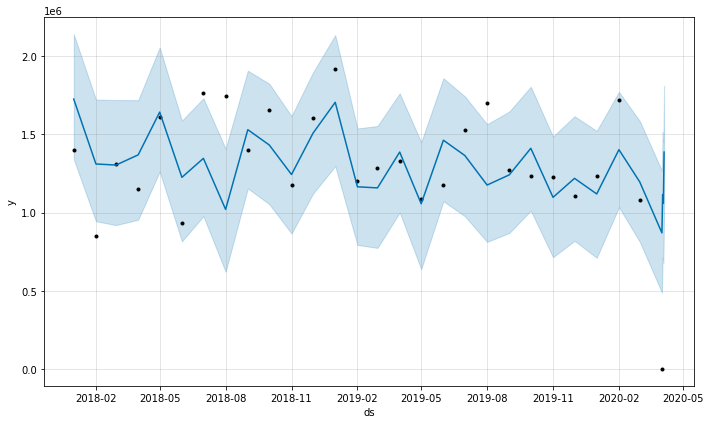

In [38]:
m.plot(forecast);

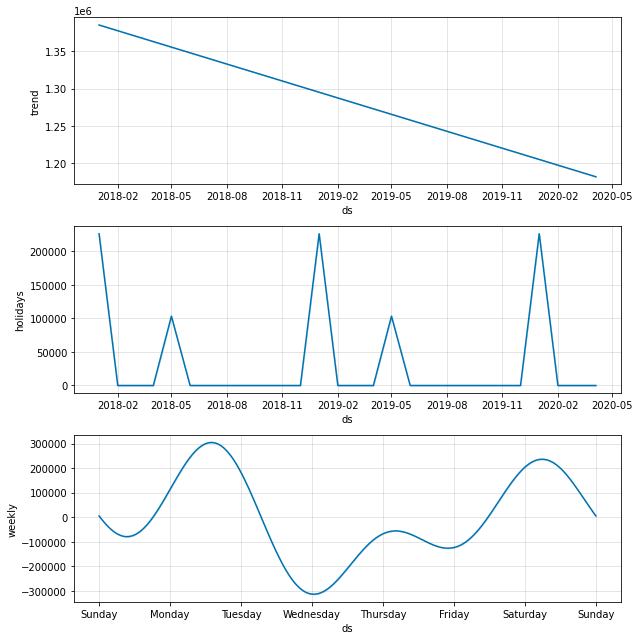

In [40]:
m.plot_components(forecast);

In [41]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

In [42]:
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='predictions'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [43]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [44]:
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']

In [45]:
# cmp_df[cmp_df.y == 0]

In [46]:
cmp_df.loc[~np.isfinite(cmp_df.p)] = np.nan
cmp_df = cmp_df.dropna()

In [47]:
# оценка качества
print(f'{round(np.mean(abs(cmp_df[-predictions:]["p"])))}% MAPE (mean absolute percentage error)')

# на сколько ошибается модель в абсолютных величинах
print(f'{round(np.mean(abs(cmp_df[-predictions:]["e"])))} MAE (mean absolute error)')

13% MAPE (mean absolute percentage error)
183513 MAE (mean absolute error)


In [53]:
predicted_months = 3

In [54]:
final_train_df = df

In [55]:
f = Prophet(holidays=holidays_data, 
            daily_seasonality=False, 
            weekly_seasonality=True, 
            yearly_seasonality=False, 
            changepoints=['2020-01-04'])

f.fit(final_train_df)

In [56]:
final_future = f.make_future_dataframe(periods=predicted_months)
final_forecast = f.predict(final_future)

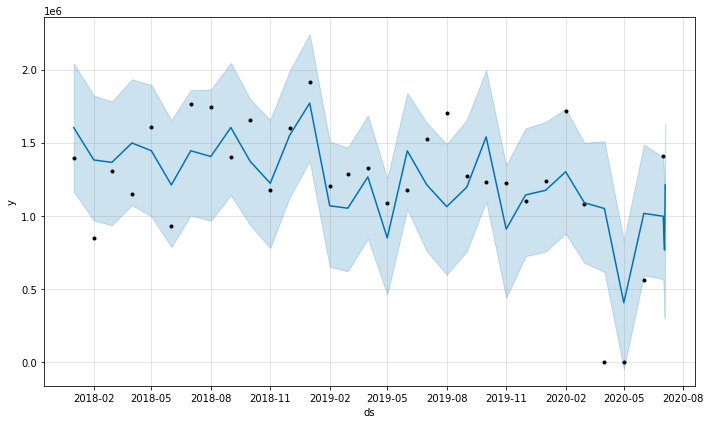

In [57]:
f.plot(final_forecast);

In [58]:
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='yhat'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])

In [199]:
# final_forecast.to_excel("./app_forecast.xlsx", sheet_name='Data', index=False, encoding="cp1251")